In [1]:
"""
Created on Thu Dec 15 17:06:37 2022

@author: Farzad Shahabi
"""

'\nCreated on Thu Dec 15 17:06:37 2022\n\n@author: Farzad Shahabi\n'

In [2]:
import pandas as pd
import warnings
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import shap 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.utils import class_weight    
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss
from scipy import interp    
import matplotlib.pyplot as plt    
from sklearn.metrics import f1_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
warnings.filterwarnings("ignore")

C:\Users\farza\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\farza\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\farza\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
random_state = 10

In [4]:
df = pd.read_csv('SMART_Trial_Weight_Features.csv', index_col=0)

In [5]:
target = df['weightloss_6mon_5prc'].astype(str)
outcome = 'weightloss_6mon_5prc'

In [6]:
#stratification
# select rows with '3' for gender and then add them randomly to train and test
gender_col_cat_3 = df.loc[df['Sex'] == 3]
df = df.loc[df['Sex'] != 3]
race_ethn_col_cat_4 = df.loc[df['Ethnicity/race'] == 4]
df = df.loc[df['Ethnicity/race'] != 4]
train_strat, test_strat = train_test_split(df, test_size=0.20, random_state=random_state, stratify=df[['Sex','weightloss_6mon_5prc']])
gender_race_ethn_concat = pd.concat([gender_col_cat_3,race_ethn_col_cat_4], axis = 0)
gender_race_ethn_concat = gender_race_ethn_concat.drop_duplicates()
train_gender_race, test_gender_race = train_test_split(gender_race_ethn_concat, test_size=0.20, random_state=random_state, stratify=gender_race_ethn_concat[['weightloss_6mon_5prc']])
train = pd.concat([train_strat, train_gender_race], axis = 0)
test = pd.concat([test_strat, test_gender_race], axis = 0)


val_gender_col_cat_3 = train.loc[train['Sex'] == 3]
train = train.loc[train['Sex'] != 3]
val_race_ethn_col_cat_4 = train.loc[train['Ethnicity/race'] == 4]
train = train.loc[train['Ethnicity/race'] != 4]



train_temp, val_temp = train_test_split(train, test_size=0.25, random_state=42, stratify=train[['Sex','weightloss_6mon_5prc']])
val_gender_race_ethn_concat = pd.concat([val_gender_col_cat_3,val_race_ethn_col_cat_4], axis = 0)
val_gender_race_ethn_concat = val_gender_race_ethn_concat.drop_duplicates()
train_gender_race, val_gender_race = train_test_split(val_gender_race_ethn_concat, test_size=0.20, random_state=random_state, stratify=val_gender_race_ethn_concat[['weightloss_6mon_5prc']])
train = pd.concat([train_temp, train_gender_race], axis = 0)
val = pd.concat([val_temp, val_gender_race], axis = 0)


#train, validation and test split
X_train = train
X_train = X_train.drop(columns=['weightloss_6mon_5prc'])
y_train = train[outcome]

X_val = val
X_val = X_val.drop(columns=['weightloss_6mon_5prc'])
y_val = val[outcome]



X_test = test
X_test = X_test.drop(columns=['weightloss_6mon_5prc'])
y_test = test[outcome]


test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_val.shape[0])]
cv = PredefinedSplit(test_fold)    

from scipy import sparse
X = sparse.vstack((X_train, X_val))
y = np.concatenate([y_train, y_val])

In [7]:
#parameter selection for random forest
param_dict = {
            "criterion": ['gini', 'entropy', 'log_loss'],               
            'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25, 30, 40, None],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15],
            'min_samples_split': [2,3,4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
            'n_estimators': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,50,70,75,80,100,125,150,175,200],
            'bootstrap': [True, False],
            'class_weight':['balanced', 'balanced_subsample', None]}    

bayes = BayesSearchCV(estimator=RandomForestClassifier(random_state=random_state), search_spaces = param_dict, cv=cv, verbose=False, scoring = 'f1_weighted', n_jobs=-1, n_iter=50, random_state=random_state)
 
    
bayes.fit(X, y)    
tuning = bayes.best_params_

opt = RandomForestClassifier(random_state=random_state, criterion=tuning['criterion'], 
      max_depth=tuning['max_depth'],
      min_samples_split=tuning['min_samples_split'],
      min_samples_leaf=tuning['min_samples_leaf'],
      max_features=tuning['max_features'],
      bootstrap=tuning['bootstrap'],
      class_weight=tuning['class_weight'],
      n_estimators=tuning['n_estimators'])

In [8]:

opt.fit(X, y)
X_train_arr = np.asarray(X_train)

predictions = opt.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
f1_score_pos = f1_score(y_test,predictions, pos_label=1)
f1_score_neg = f1_score(y_test,predictions, pos_label=0)
f1_weighted = f1_score(y_test, predictions, average='weighted')
Sensitivity = np.round(tp/(tp+fn),3)
Specificity = np.round(tn/(fp+tn),3) 
predictions_train = opt.predict(X_train)
f1_score_pos_tr = f1_score(y_train,predictions_train, pos_label=1)
f1_score_neg_tr = f1_score(y_train,predictions_train, pos_label=0)
predictions_val = opt.predict(X_val)
f1_score_pos_val = f1_score(y_val,predictions_val, pos_label=1)
f1_score_neg_val = f1_score(y_val,predictions_val, pos_label=0)
   
explainer = shap.TreeExplainer(opt)
predictions_df = pd.DataFrame(predictions)
predictions_df.index = y_test.index
FP_df = X_test[(y_test == 0) & (predictions == 1)]
FN_df = X_test[(y_test == 1) & (predictions == 0)]
TP_df = X_test[(y_test == 1) & (predictions == 1)]
TN_df = X_test[(y_test == 0) & (predictions == 0)]

Text(0.5, 78.9, 'mean(|SHAP value|)')

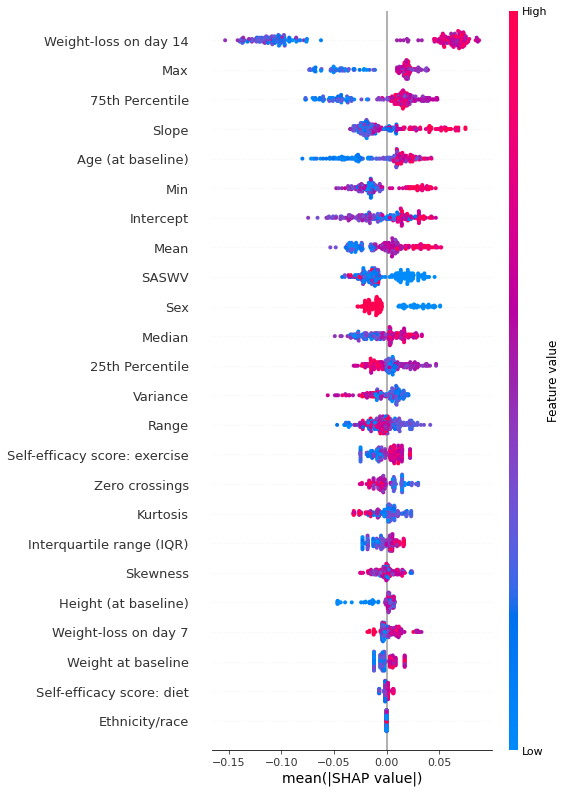

In [21]:
X_new = pd.DataFrame.sparse.from_spmatrix(X)
X_new.columns = X_train.columns.values.tolist()
shap_values = explainer.shap_values(X_new, approximate=False, check_additivity=False)
shap.summary_plot(shap_values[1],X_new, max_display=50, plot_type="dot",  show=False)
plt.xlabel('mean(|SHAP value|)', fontsize=14) 

Text(0.5, 78.9, 'mean(|SHAP value|)')

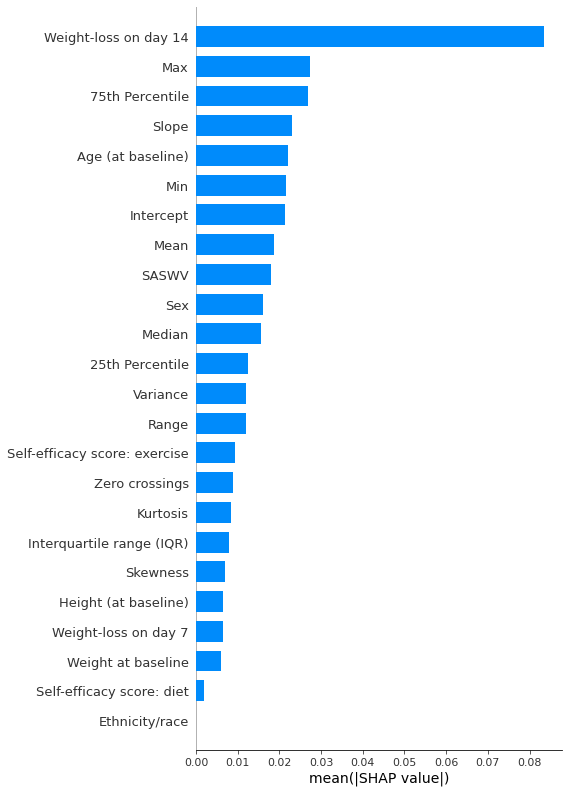

In [22]:
shap.summary_plot(shap_values[1],X_new, max_display=50, plot_type="bar",  show=False)
plt.xlabel('mean(|SHAP value|)', fontsize=14) 

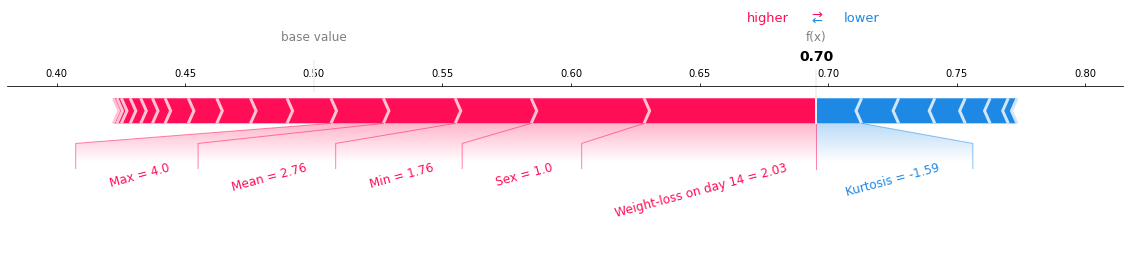

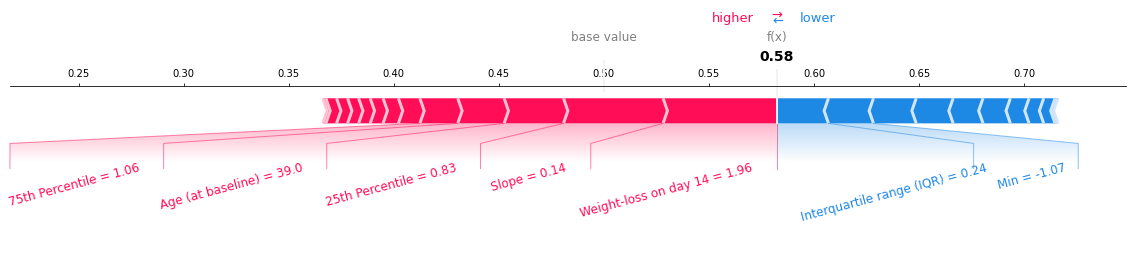

In [10]:
for i in [6001, 6592]:
    plt.switch_backend('agg')
    row_to_show = i
    data_for_prediction =  X_test.loc[[row_to_show]].round(2)
 
    shap_values = explainer.shap_values(data_for_prediction)
    shap.initjs()
    shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction, matplotlib=True, text_rotation=15, contribution_threshold=0.065)
    #plt.savefig('final_explainability'+str(i)+'.pdf', format='pdf', bbox_inches="tight", dpi=1200)
    plt.show()

In [11]:
# Compute ROC curve and ROC area for each class

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_score = opt.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [12]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [16]:
f1_score_final = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precisions = []
ap_scores = []
mean_recall = np.linspace(0, 1, 100)
mean_predicted_value_list = []
fraction_of_positives_list = []
clf_score = []


yhat = opt.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
scores_weighted = [f1_score(y_test, to_labels(probs, t), average = 'weighted') for t in thresholds]
# get best threshold
ix = np.argmax(scores)
#print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
#print('Threshold=%.3f, F-Score weighted=%.5f' % (thresholds[ix], scores_weighted[ix]))
f1_score_final.append(scores[ix])


y_score = opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score,sample_weight=class_weight.compute_sample_weight('balanced', y_test))
precisions.append(interp(mean_recall, recall[::-1], precision[::-1]))
ap_score = average_precision_score(y_test, y_score, sample_weight=class_weight.compute_sample_weight('balanced', y_test))
ap_scores.append(ap_score)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_score, n_bins=10, strategy='quantile')
mean_predicted_value_list.append(mean_predicted_value)
fraction_of_positives_list.append(fraction_of_positives)
clf_score.append( brier_score_loss(y_test, y_score, sample_weight=class_weight.compute_sample_weight('balanced', y_test)))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

mean_precision = np.mean(precisions, axis=0)
mean_ap = np.mean(ap_scores)


In [23]:

final_metrics = {
    'Metric': ['AUC (ROC)', 'AP (Precision-Recall)', 'Brier Score', 
               'F1 Score (Positive)', 'F1 Score (Negative)', 'F1 Score (Weighted)', 
               ],
    'Value': [
        np.round(roc_auc*100, 3), 
        np.round(mean_ap*100, 3), 
        np.round(clf_score[0], 3), 
        np.round(f1_score_pos*100, 3), 
        np.round(f1_score_neg*100, 3), 
        np.round(f1_weighted*100, 3), 

    ]
}
  

metrics_summary = pd.DataFrame(final_metrics)  

In [24]:
metrics_summary

,Metric,Value
0,AUC (ROC),84.545
1,AP (Precision-Recall),86.289
2,Brier Score,0.173
3,F1 Score (Positive),72.000
4,F1 Score (Negative),78.125
5,F1 Score (Weighted),75.761
